# Learning Synaptic Delays (LSD) is good for spiking neurons

# Methods

## Create a structured pattern in noise

In [1]:
nb_syn, noise_density, simtime, t_true = 50, 1e-2, 1e3, .5e3
T = 100

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def norm(X):
    return (X-X.min())/(X.max()-X.min())

def vonmises(N_inputs, A, theta, k=2):
    return A*norm(np.exp(k*np.cos(2*np.pi*(np.linspace(0, 1, N_inputs)-theta))))

def cospattern(N_inputs, A, theta, k=4):
    return A*norm(np.cos(k*np.pi*(np.linspace(0, 1, N_inputs)-theta)))

def linear(N_inputs, A, theta):
    return np.linspace(0, A, N_inputs)

def make_input(nb_syn, noise_density, simtime, T, t_true, theta=0, function=cospattern, seed=None):
    np.random.seed(seed)
    # draw random gaussian noise spike timings -> shape (nb_syn, nb_ev_noise)
    N_noise = int(noise_density*simtime*nb_syn)
    adress_noise = np.random.randint(0, nb_syn, N_noise)
    time_noise = np.random.rand(N_noise)*simtime

    # draw stimulus -> stim
    adress_pattern = np.arange(nb_syn)
    time_pattern = function(nb_syn, T, theta) + t_true #.astype(int)

    # make address event representation
    all_timestamps = np.hstack((time_noise, time_pattern))
    all_addresses = np.hstack((adress_noise, adress_pattern))
    sorted_timestamps = np.argsort(all_timestamps)
    aer = (all_addresses[sorted_timestamps], all_timestamps[sorted_timestamps])

    return (adress_noise, time_noise), (adress_pattern, time_pattern), aer

def plot_input(aer_noise, aer_pattern):
    adress_noise, time_noise = aer_noise
    adress_pattern, time_pattern = aer_pattern
    fig, ax = plt.subplots(figsize = (4, 4))
    pattern = ax.scatter(time_pattern, adress_pattern, marker='|', color='blue', alpha = 1, label = 'pattern');
    noise = ax.scatter(time_noise, adress_noise, marker='|', color='grey', alpha = .6, label = 'noise')
    #ax.legend()
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('neuron adress')
    ax.set_title('neural activity')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    return fig, ax

Decomposing the function:

* temporal patern

In [3]:
time_pattern = t_true + cospattern(nb_syn, T, theta=0)
t_true, time_pattern

(500.0,
 array([600.        , 598.36306152, 593.55931867, 585.90298559,
        575.89486512, 564.18959117, 551.5528089 , 538.81109372,
        526.79788469, 516.29896911, 508.00108394, 502.44699609,
        500.        , 500.82015434, 504.85381258, 511.83713205,
        521.31333189, 532.66257129, 545.14249339, 557.93678306,
        570.2085623 , 581.15513069, 590.06047018, 596.34208007,
        599.58907855, 599.58907855, 596.34208007, 590.06047018,
        581.15513069, 570.2085623 , 557.93678306, 545.14249339,
        532.66257129, 521.31333189, 511.83713205, 504.85381258,
        500.82015434, 500.        , 502.44699609, 508.00108394,
        516.29896911, 526.79788469, 538.81109372, 551.5528089 ,
        564.18959117, 575.89486512, 585.90298559, 593.55931867,
        598.36306152, 600.        ]))

Different components:

In [4]:
(adress_noise, time_noise), (adress_pattern, time_pattern), aer = make_input(nb_syn, noise_density, simtime, T, t_true, theta=0, function=cospattern, seed=None)

Text(0.5, 1.0, 'Input Raster Plot')

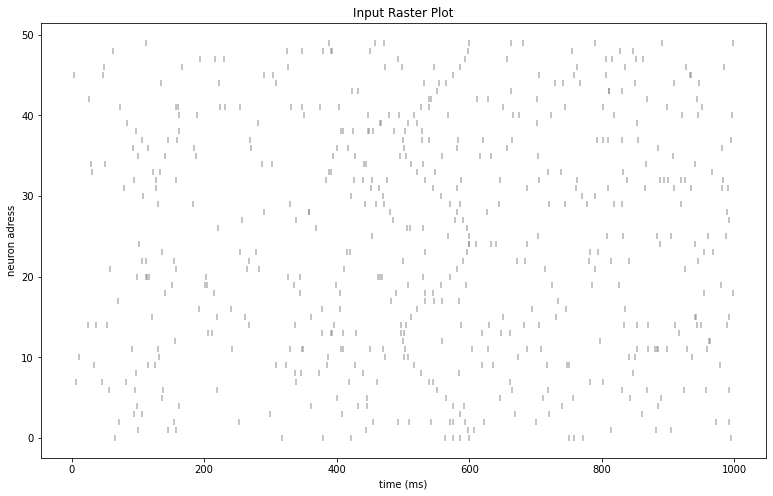

In [5]:
address, timestamp = aer
fig, ax = plt.subplots(figsize = (13, 8))
ax.scatter(timestamp, address, marker='|', color='grey', alpha = .6);
plt.xlabel('time (ms)')
plt.ylabel('neuron adress')
plt.title('Input Raster Plot')

## Problem statement:

from a raster plot 

Text(0.5, 1.0, 'Input Raster Plot')

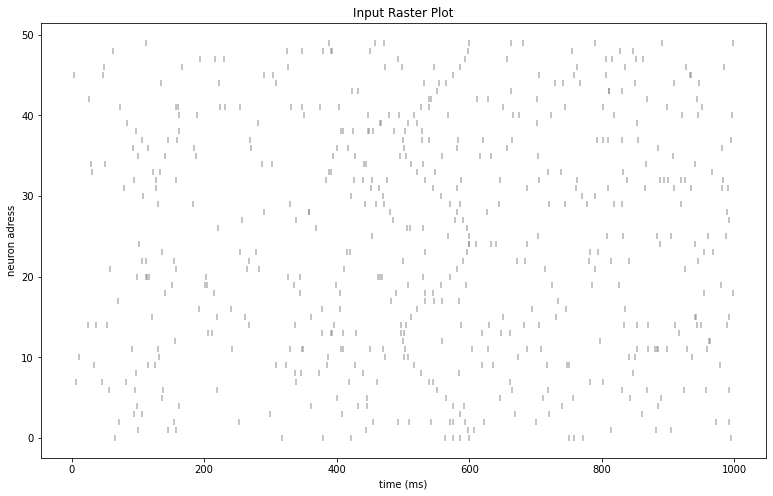

In [6]:
address, timestamp = aer
fig, ax = plt.subplots(figsize = (13, 8))
ax.scatter(timestamp, address, marker='|', color='grey', alpha = .6);
plt.xlabel('time (ms)')
plt.ylabel('neuron adress')
plt.title('Input Raster Plot')

... extract the signal from the noise ...

In [7]:
aer_noise, aer_pattern = (adress_noise, time_noise), (adress_pattern, time_pattern)

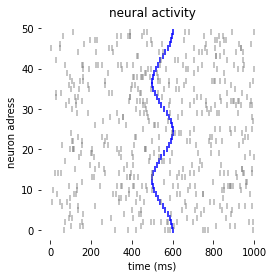

In [8]:
fig, ax = plot_input(aer_noise, aer_pattern)

## a leaky Integrate and fire neurons implemented in an event-based fashion

In [9]:
T = 100 # duration of a stimulus

class SD_neuron(object):
    """
    Synchrony detector neuron
    
    """
    def __init__(self, nb_syn, T=T,  tau=50, weight=.07):
        self.delays = np.random.rand(nb_syn) * T 
        self.tau = tau # membrane time constant
        self.weight = weight # integration weight

    def code(self, aer):
        addresses, timestamps = aer

        delayed_timestamps = timestamps + self.delays[addresses]

        #sorted_ind_times = np.argsort(delayed_timestamps)
        sorted_times = np.sort(delayed_timestamps)
        dts = np.diff(np.hstack((0, sorted_times))) # = time[ev]-time[ev-1]
        V = np.zeros_like(dts) #=len(dts)
        for i, dt in enumerate(dts):
            if i==0: 
                V[i] = 0
            else:
                if V[i-1]>1: 
                    V[i] = 0.
                else:
                    V[i] = np.exp( - dt / self.tau) * V[i-1] + self.weight # potentiel de membrane ? 
        
        #V = self.weight * np.arange(len(addresses)) #* np.exp(-sorted_times/self.tau)
        
        #return delayed_timestamps[sorted_ind_times], V
        return sorted_times, V

Text(0.5, 1.0, 'evolution of the membrane potential as a function of time')

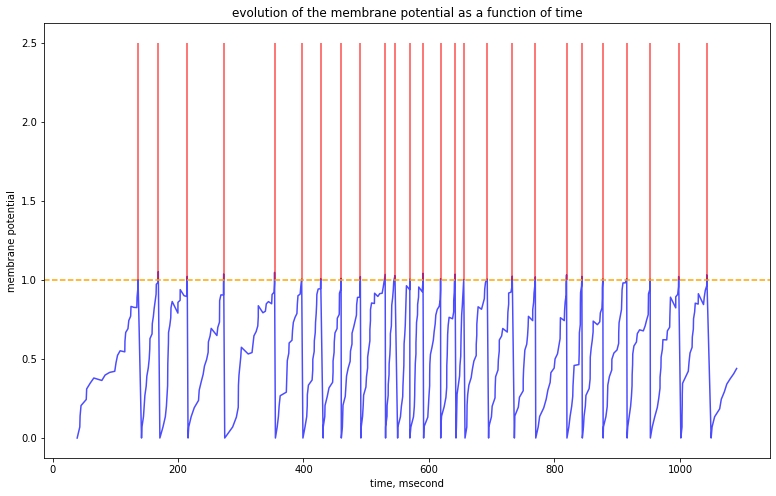

In [10]:
N = SD_neuron(nb_syn)

sorted_times, V = N.code(aer)
fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(sorted_times, V, color='blue', alpha = .7, linewidth=1.5); 
#axs['A'].vlines([t_true+T], 0, 1, color='black')
if V.max() > 1: ax.vlines(sorted_times[V>1], 1, 2.5, color='red', alpha = .7, label = 'First spike = detection of the pattern') # spike
#axhline(y, color, xmin, xmax, linestyle)
plt.axhline(1, 0, simtime, color='orange', linestyle='dashed')
plt.xlabel('time, msecond')
plt.ylabel('membrane potential')
plt.title('evolution of the membrane potential as a function of time')

# V en fonction du temps des spikes 

In [11]:
np.argmax(V>1) # = t_out

26

In [12]:
t_out = sorted_times[np.argmax(V>1)]
t_out

136.3518390446994

In [13]:
np.random.rand()*(simtime-T)

234.22208283505756

# Results: experiment 1 - supervised learning of a single spiking motif

## Supervised STDP learning rule

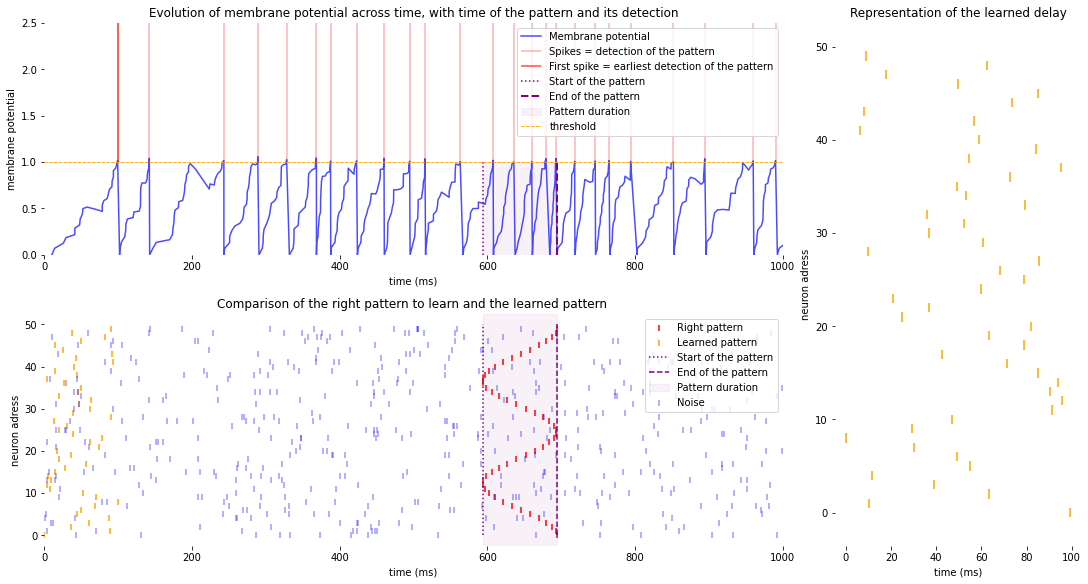

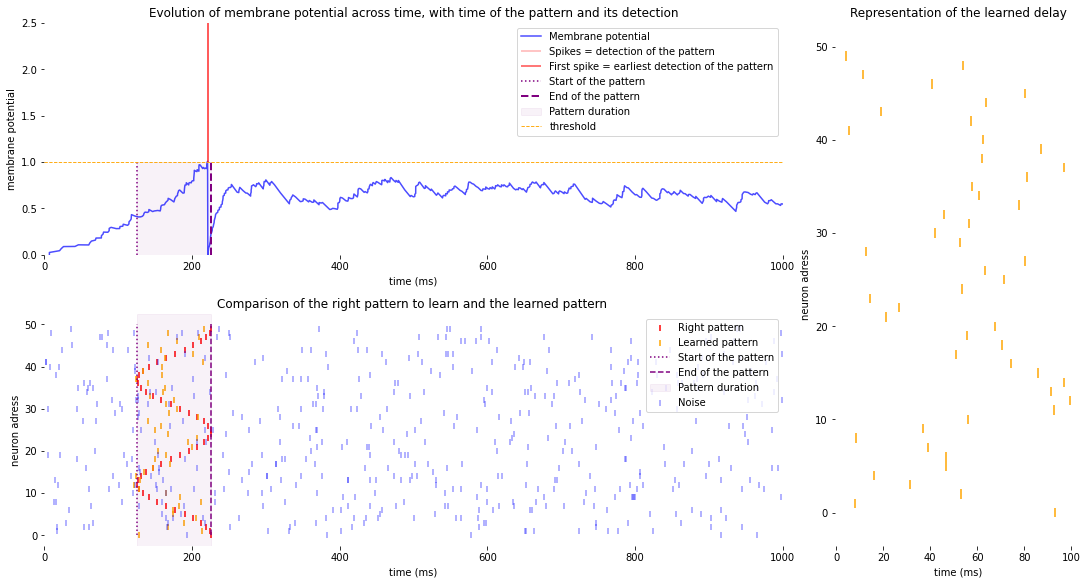

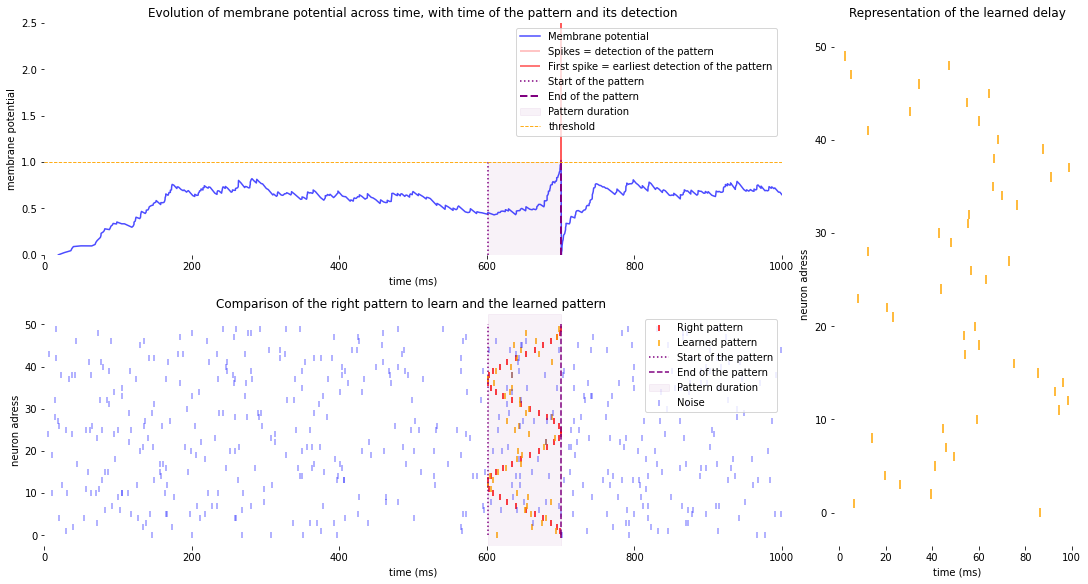

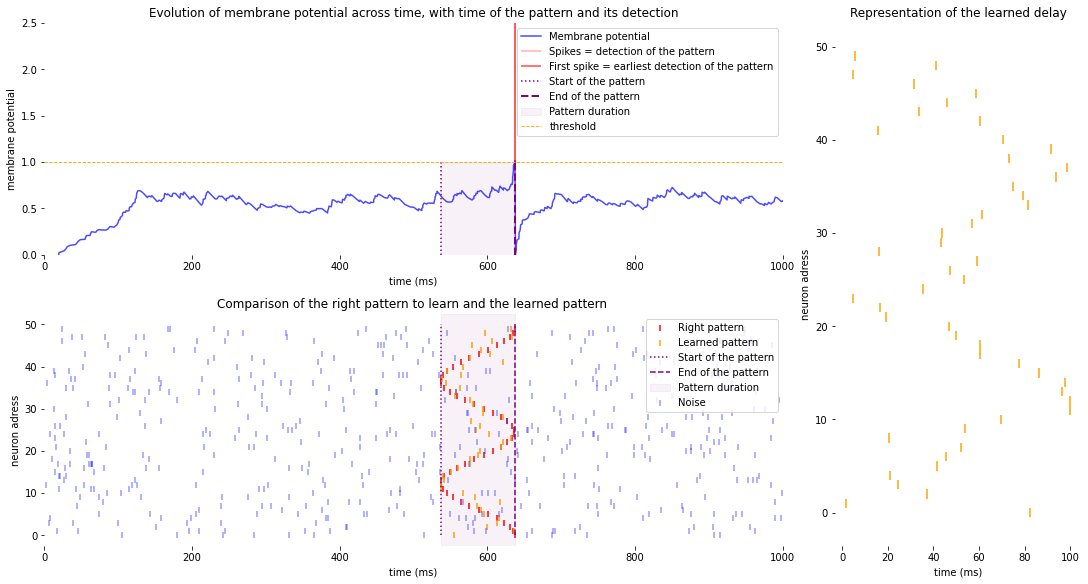

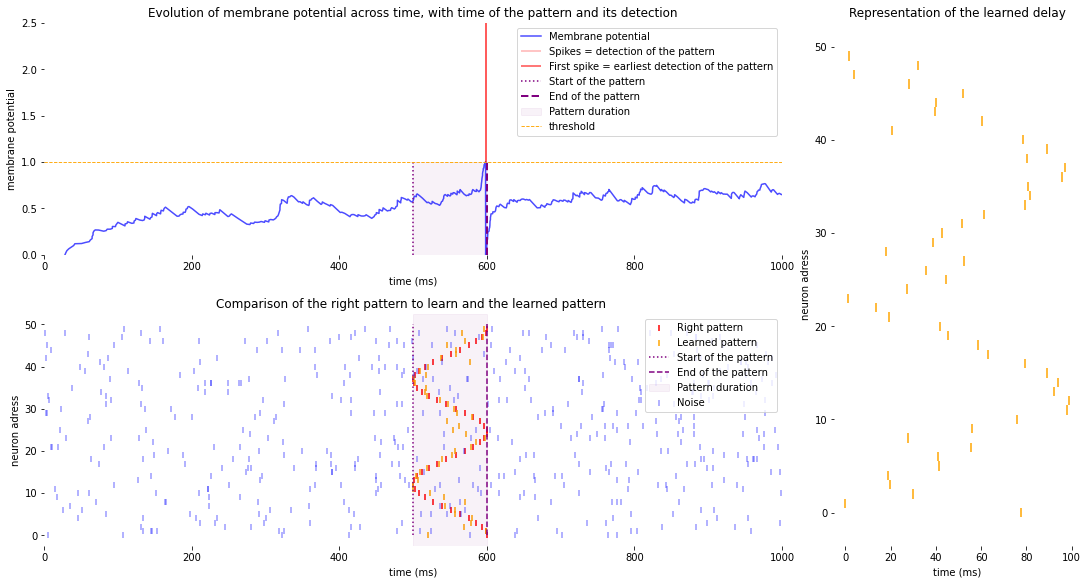

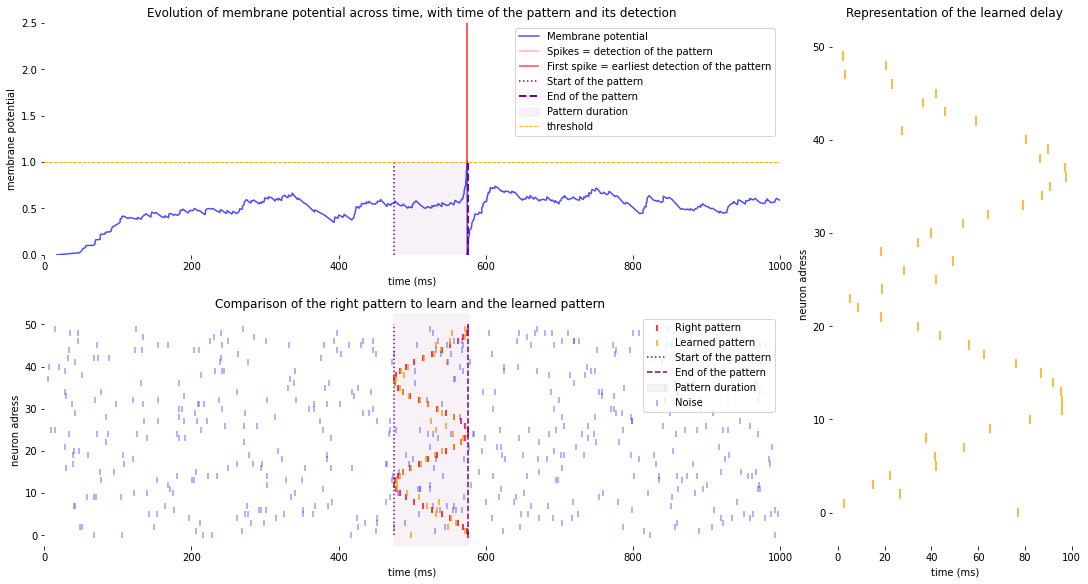

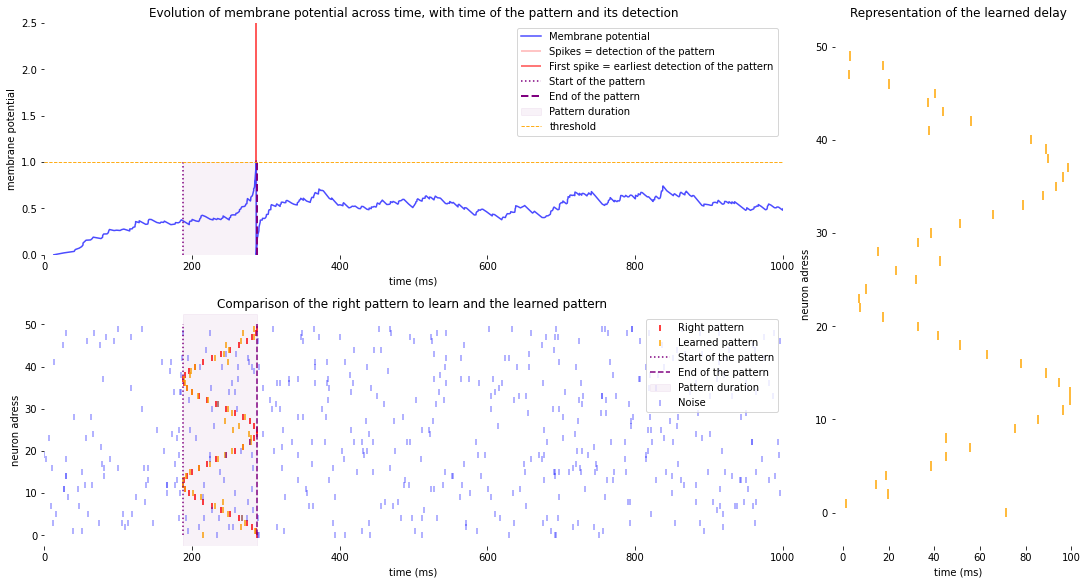

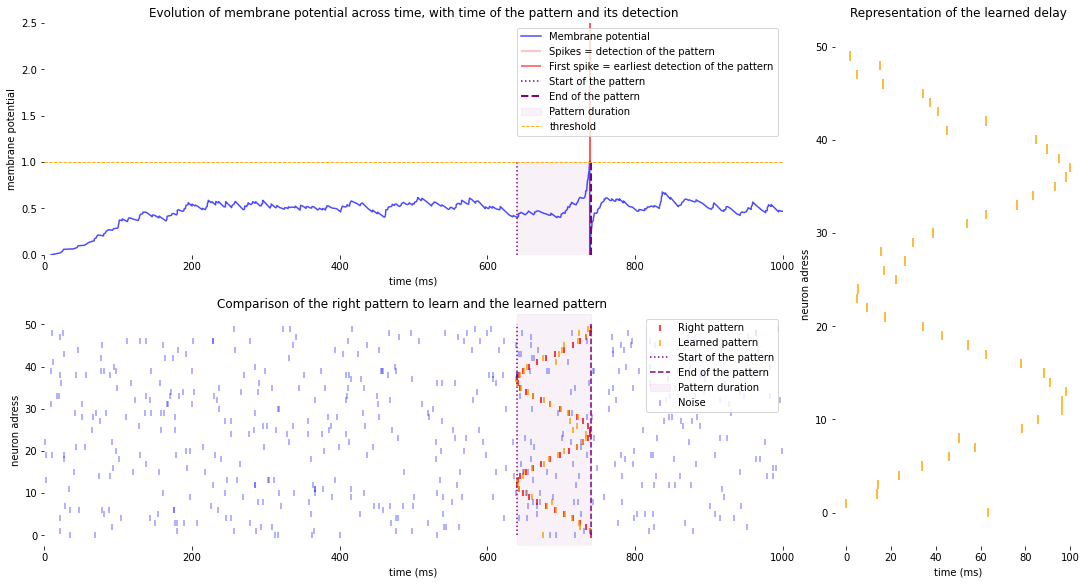

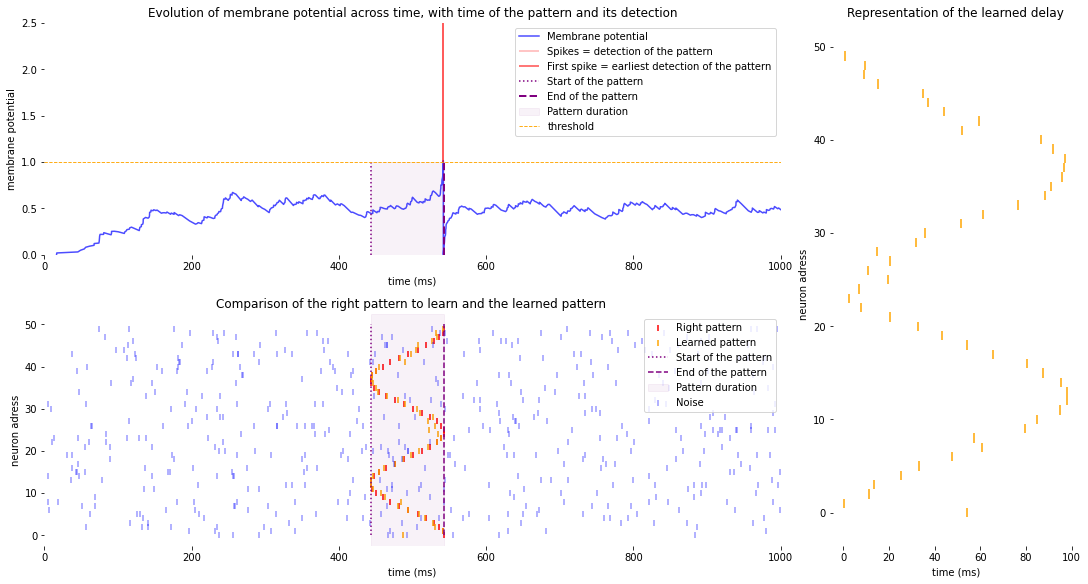

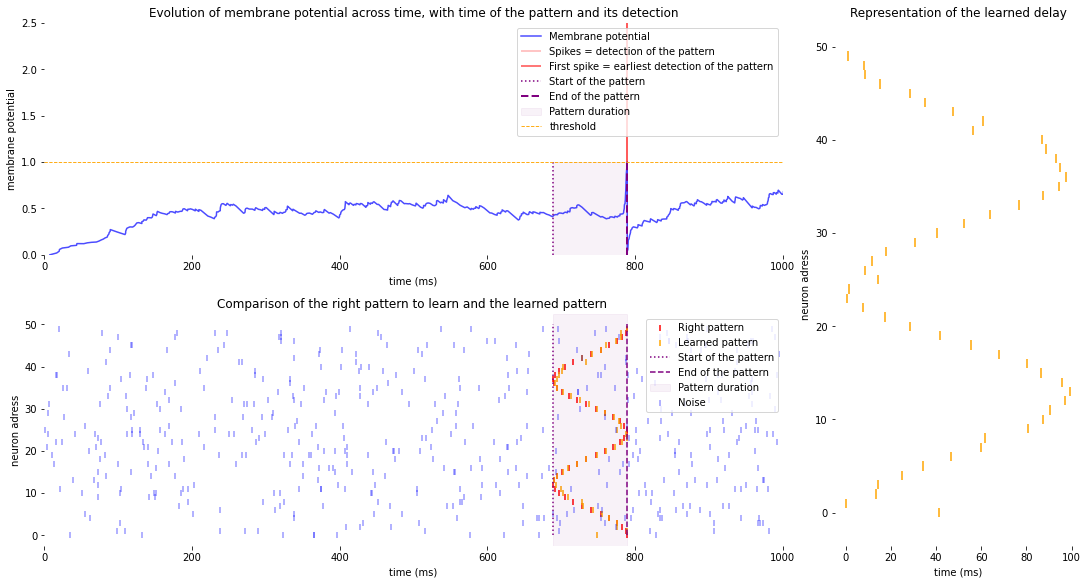

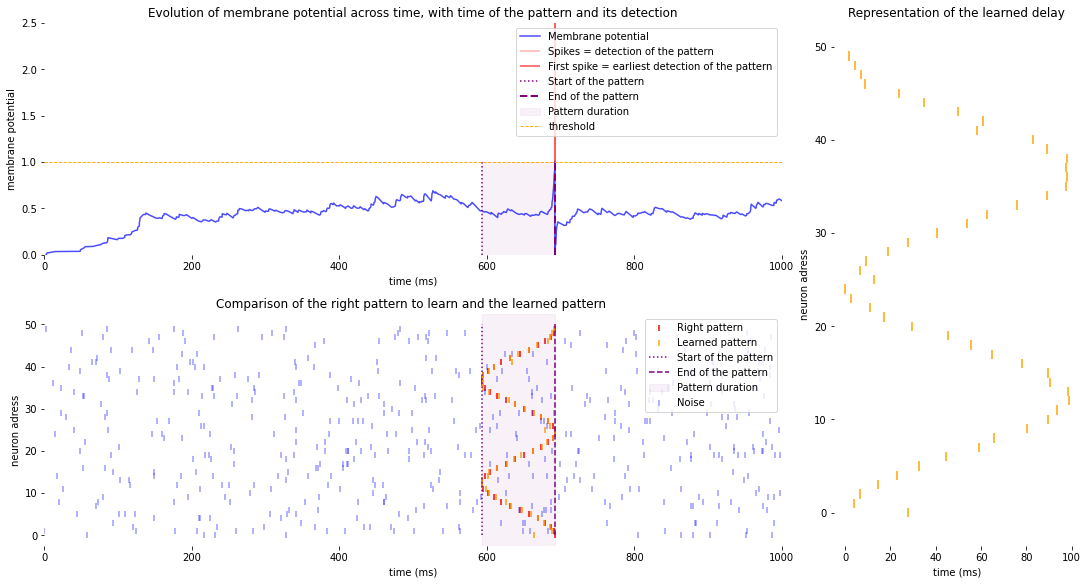

In [14]:
def learning(noise_density, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs = 151, do_plot=False):
    N = SD_neuron(nb_syn)

    for i_epoch in range(N_epochs):
        #t_true = 500 
        #t_true = int(np.random.rand()*(simtime-T))
        t_true = T + int(np.random.rand()*(simtime-3*T))
        
        aer_noise, aer_pattern, aer = make_input(nb_syn, noise_density, simtime, T, t_true)
        sorted_times, V = N.code(aer)

        # STDP rule on the weights
        if V.max() < 1: # does not spike : the weight is too low
            Dweight = Dweight0
        else:
            t_out = sorted_times[np.argmax(V>1)] # output spike
            time_error = (t_true+T) - t_out # delta_T, negative = too early, positive = too late -> supervision
            Dweight = Dweight0 * np.tanh( - time_error / N.tau ) #STDP

            # STDP rule on the delays, event by event
            addresses, timestamps = aer
            for i_address, (address, timestamp) in enumerate(zip(addresses, timestamps)):
                # predicted time by neuron:
                pred_time = t_true +  T - N.delays[address] # 
                # timestamp is that of the i_address-th event - it is fired on synapse address
                delay_pred_error = pred_time - timestamp # 
                # STDP rule
                Ddelay = Ddelay0 * np.tanh( delay_pred_error / N.tau ) * np.exp( - np.abs(delay_pred_error) / N.tau )
                
                # clip delays
                delay = N.delays[address]
                delay += Ddelay
                delay= np.min((delay, T))
                delay = np.max((delay, 0))
                N.delays[address] = delay

        N.weight *= 1 + Dweight 

        if do_plot:
            if i_epoch % (N_epochs//10) == 0:
                #print(i_epoch, i_epoch % (N_epochs//10), i_epoch // (N_epochs//10))
                fig = plt.figure(constrained_layout=True, figsize = (15, 8))
                axs = fig.subplot_mosaic(
                """
                AAAC
                BBBC
                """
                )

                axs['A'].plot(sorted_times, V, color='blue', alpha = .7, label = 'Membrane potential')
                if V.max() > 1: 
                    axs['A'].vlines(sorted_times[V>1], 1, 2.5, color='red', alpha = .3, label = 'Spikes = detection of the pattern') # spike
                    axs['A'].vlines([t_out], 1, 2.5, color='red', alpha = .7, label = 'First spike = earliest detection of the pattern') # spike
                axs['A'].vlines([t_true], 0, 1, linestyles='dotted', color='purple', label = 'Start of the pattern')
                axs['A'].vlines([t_true+T], 0, 1, linestyles='dashed', color='purple', lw = 2, label = 'End of the pattern')
                axs['A'].axvspan( xmin = t_true, xmax = t_true+T, ymin=0, ymax=.4, color = 'purple', alpha = .05, label = 'Pattern duration')
                
                axs['A'].hlines(1, 0, simtime, color = 'orange',linestyles='--', label = 'threshold', linewidth = .9)
                
                axs['A'].set_xlim(0, simtime)
                axs['A'].set_ylim(0, 2.5)
                
                axs['A'].legend(loc = 'upper right')
                axs['A'].set_xlabel('time (ms)')
                axs['A'].set_ylabel('membrane potential')
                axs['A'].set_title('Evolution of membrane potential across time, with time of the pattern and its detection')
                axs['A'].spines['top'].set_visible(False)
                axs['A'].spines['right'].set_visible(False)
                axs['A'].spines['left'].set_visible(False)
                axs['A'].spines['bottom'].set_visible(False)
                adress_noise, time_noise = aer_noise
                adress_pattern, time_pattern = aer_pattern
                i_adress = np.arange(len(adress_pattern))
                
                axs['B'].scatter(time_pattern, adress_pattern, marker='|', color='red', label = 'Right pattern');
                axs['B'].scatter(t_out - N.delays[:,np.newaxis], i_adress, marker = '|', color = 'orange', label = 'Learned pattern')
                
                axs['B'].vlines(t_true, 0, 50, linestyles='dotted', color='purple', label = 'Start of the pattern')
                axs['B'].vlines(t_true+T, 0, 50, color='purple', linestyles = 'dashed', label = 'End of the pattern')
                axs['B'].axvspan(t_true, t_true+T, 0, 1, color = 'purple', alpha = .05, label = 'Pattern duration')
                
                axs['B'].scatter(time_noise, adress_noise, marker='|', color='blue', alpha = .4, label = 'Noise')
                
                axs['B'].set_xlim(0, simtime)
                axs['B'].legend(loc = 'upper right')
                axs['B'].set_xlabel('time (ms)')
                axs['B'].set_ylabel('neuron adress')
                axs['B'].set_title('Comparison of the right pattern to learn and the learned pattern ')
                axs['B'].spines['top'].set_visible(False)
                axs['B'].spines['right'].set_visible(False)
                axs['B'].spines['left'].set_visible(False)
                axs['B'].spines['bottom'].set_visible(False)
                
                axs['C'].eventplot(N.delays[:,np.newaxis], color = 'orange')
                axs['C'].set_xlabel('time (ms)')
                axs['C'].set_ylabel('neuron adress')
                axs['C'].set_title('Representation of the learned delay')
                axs['C'].spines['top'].set_visible(False)
                axs['C'].spines['right'].set_visible(False)
                axs['C'].spines['left'].set_visible(False)
                axs['C'].spines['bottom'].set_visible(False)
                plt.show()

    return N

N = learning(noise_density, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs = 151, do_plot=True)

#### figures

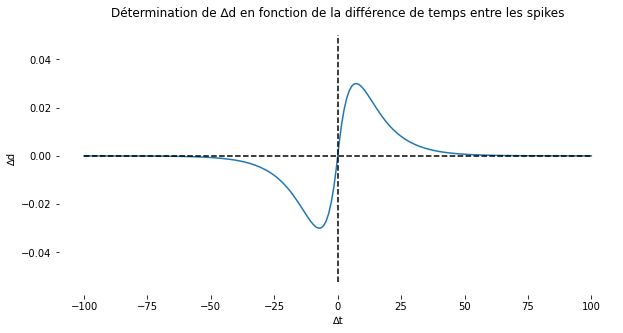

In [15]:
tau_pre = tau_post = 10
A_pre = 0.1
A_post = -A_pre*1.05
delta_t = np.linspace(-100, 100, 200)

w_stdp =  A_pre*np.tanh(delta_t/tau_pre)*np.exp( - np.abs(delta_t) / tau_pre )
    
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(delta_t, w_stdp)
plt.hlines(0, -100, 100, linestyles='--', color= 'k')
plt.vlines(0, A_post/2, A_pre/2, linestyles = '--', color= 'k')
ax.set_xlabel('∆t')
ax.set_ylabel('∆d')
ax.set_title('Détermination de ∆d en fonction de la différence de temps entre les spikes')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [16]:
delay = np.random.randint(T, size = len(N.delays))
dress_noise, time_noise = aer_noise
adress_pattern, time_pattern = aer_pattern

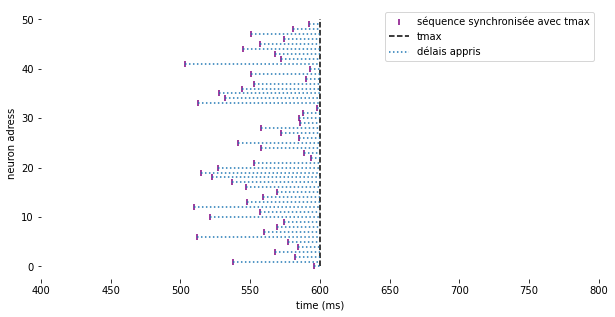

In [17]:
fig, ax = plt.subplots(figsize = (10, 5))
#ax.scatter(time_pattern, adress_pattern, marker='|', color='red', label = 'séquence spatio-temporelle');
ax.scatter(t_true+T-delay, adress_pattern, marker = '|', color = 'purple', label ='séquence synchronisée avec tmax')
                
#axs['B'].vlines(t_true, 0, 50, linestyles='dotted', color='purple', label = 'Start of the pattern')
ax.vlines(t_true+T, 0, 50, color = 'black', linestyles = 'dashed', label = 'tmax')
#axs['B'].axvspan(t_true, t_true+T, 0, 1, color = 'purple', alpha = .05, label = 'Pattern duration')
#ax.hlines(adress_pattern, time_pattern, t_true+T - delay, color = 'orange', linestyles = 'dashed', label = 'delta t')     
ax.hlines(adress_pattern, t_true+T-delay, t_true+T, linestyles = 'dotted', label = 'délais appris')  
#ax.scatter(time_noise, adress_noise, marker='|', color='blue', alpha = .4, label = 'Noise')
ax.set_xlim(400, 800)
ax.legend(loc = 'upper right')
ax.set_xlabel('time (ms)')
ax.set_ylabel('neuron adress')
#ax.set_title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

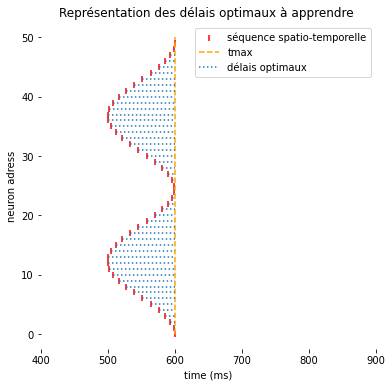

In [18]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(time_pattern, adress_pattern, marker='|', color='red', label = '''séquence spatio-temporelle''');
#ax.scatter(t_true+T - delay, i_adress, marker = '|', color = 'orange', label = 't true - d')
                
#axs['B'].vlines(t_true, 0, 50, linestyles='dotted', color='purple', label = 'Start of the pattern')
ax.vlines(t_true+T, 0, 50, color='orange', linestyles = 'dashed', label = 'tmax')
#axs['B'].axvspan(t_true, t_true+T, 0, 1, color = 'purple', alpha = .05, label = 'Pattern duration')
ax.hlines(adress_pattern, time_pattern, t_true+T, label = 'délais optimaux', linestyles = 'dotted')                
#ax.scatter(time_noise, adress_noise, marker='|', color='blue', alpha = .4, label = 'Noise')
ax.set_xlim(400, 900)
ax.legend(loc = 'upper right')
ax.set_xlabel('time (ms)')
ax.set_ylabel('neuron adress')
ax.set_title('Représentation des délais optimaux à apprendre ')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

## testing the STDP learning rule

Testing how well the pattern of delay is found as a function of noise density:

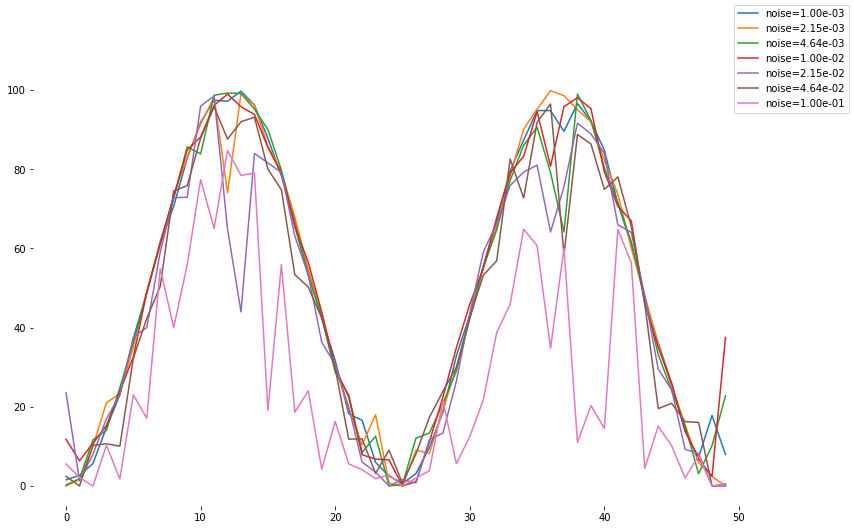

In [19]:
fig, ax = plt.subplots(figsize = (13, 8))
for noise_density_ in noise_density * np.logspace(-1, 1, 7, base=10):
    N = learning(noise_density_, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs = 151, do_plot=False)
    ax.plot(N.delays, label=f'noise={noise_density_:.2e}')
    
ax.set_xlabel = 'neuron adress'
ax.set_ylabel = 'learned delays'
ax.set_title = 'Impact of noise density on delay learning'
fig.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
                

TODO: montrer `sum | delay - N.delay |^2 |` en fonction de noise dans un plot

Testing how well the pattern of delay is found as a function of Dweight0:

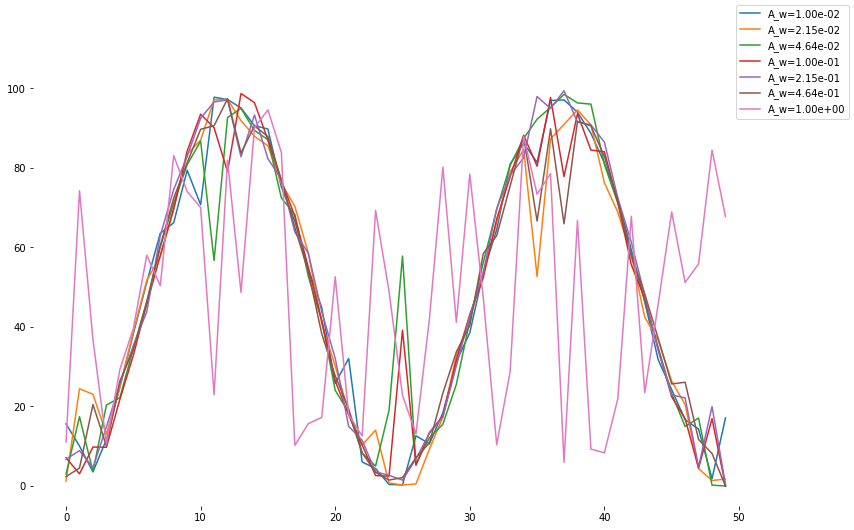

In [20]:
fig, ax = plt.subplots(figsize = (13, 8))
for Dweight0_ in 1e-1 * np.logspace(-1, 1, 7, base=10):
    N = learning(noise_density, T, Dweight0=Dweight0_, Ddelay0 = 2., N_epochs = 151, do_plot=False)
    ax.plot(N.delays, label=f'A_w={Dweight0_:.2e}');
    
fig.set_xlabel = 'neuron adress'
fig.set_ylabel = 'learned delays'
fig.set_title = 'Impact of D0weight on delay learning'
fig.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

TODO: Testing how well the pattern of delay is found as a function of `Ddelay0`:

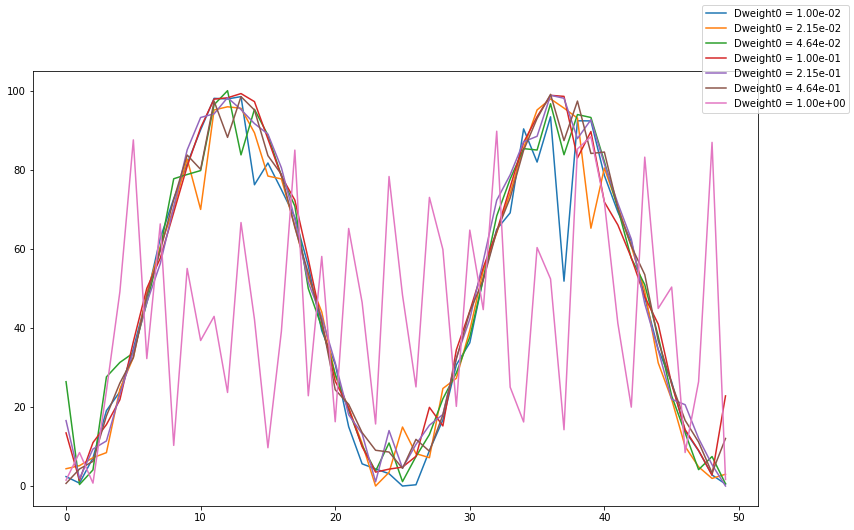

In [21]:
fig, ax = plt.subplots(figsize = (13, 8))
for Dweight0_ in 1e-1 * np.logspace(-1, 1, 7, base=10):
    N = learning(noise_density, T, Dweight0=Dweight0_, Ddelay0 = 2., N_epochs = 151, do_plot=False)
    ax.plot(N.delays, label=f'Dweight0 = {Dweight0_:.2e}');
fig.legend()

# Results: experiment 2 - supervised learning of multiple spiking motifs

### STDP learning rule for learning of several motifs

-> en entrée : des make_input de 3 shape différentes
-> en sortie 3 neurones 

epoch : 0 seq : 0 motif : cosine N : 0
591


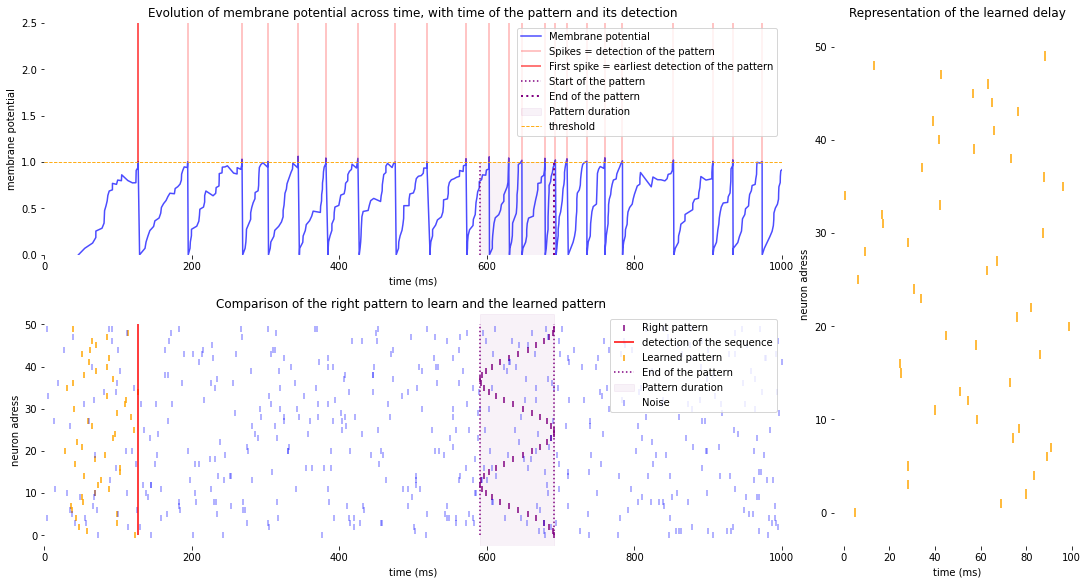

epoch : 0 seq : 0 motif : cosine N : 1
591


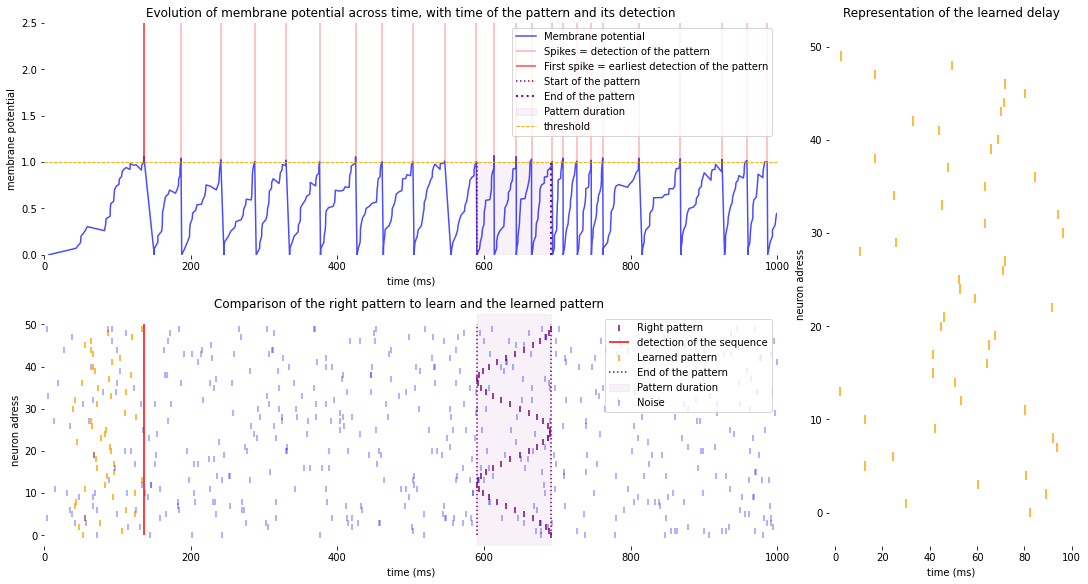

epoch : 0 seq : 0 motif : cosine N : 2
591


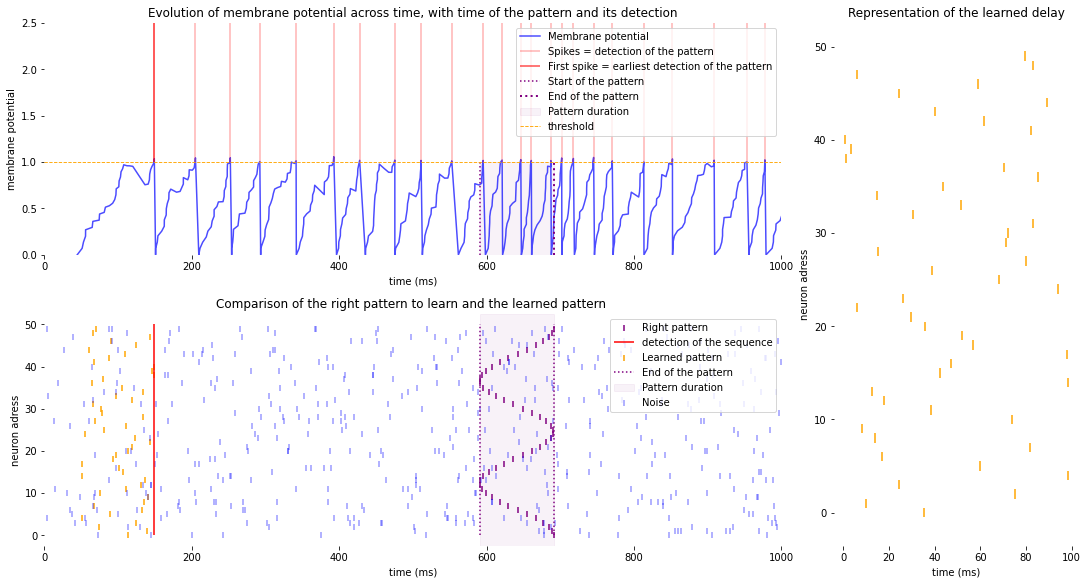

epoch : 0 seq : 1 motif : linear N : 0
687


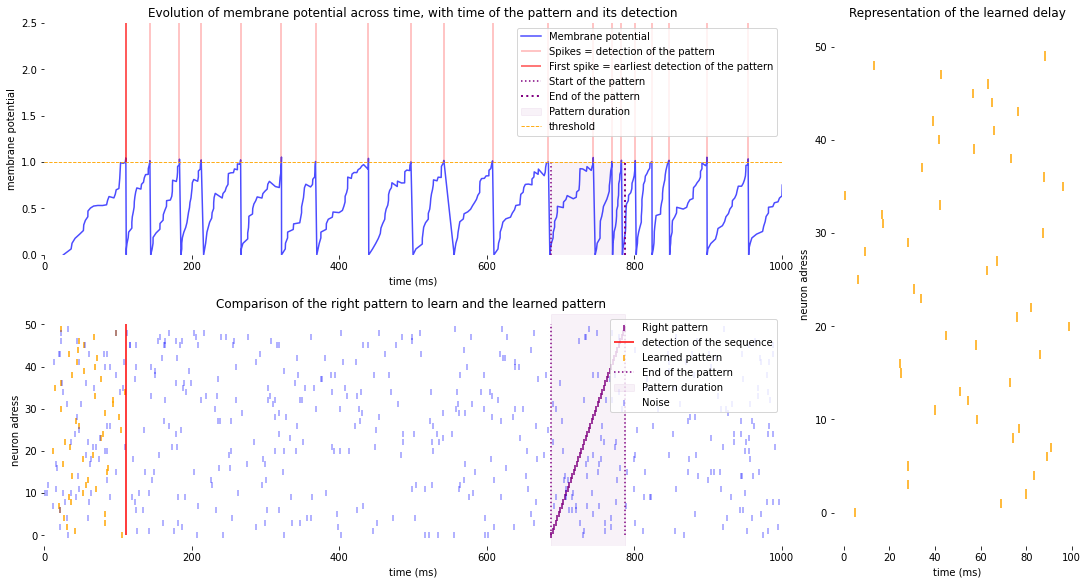

epoch : 0 seq : 1 motif : linear N : 1
687


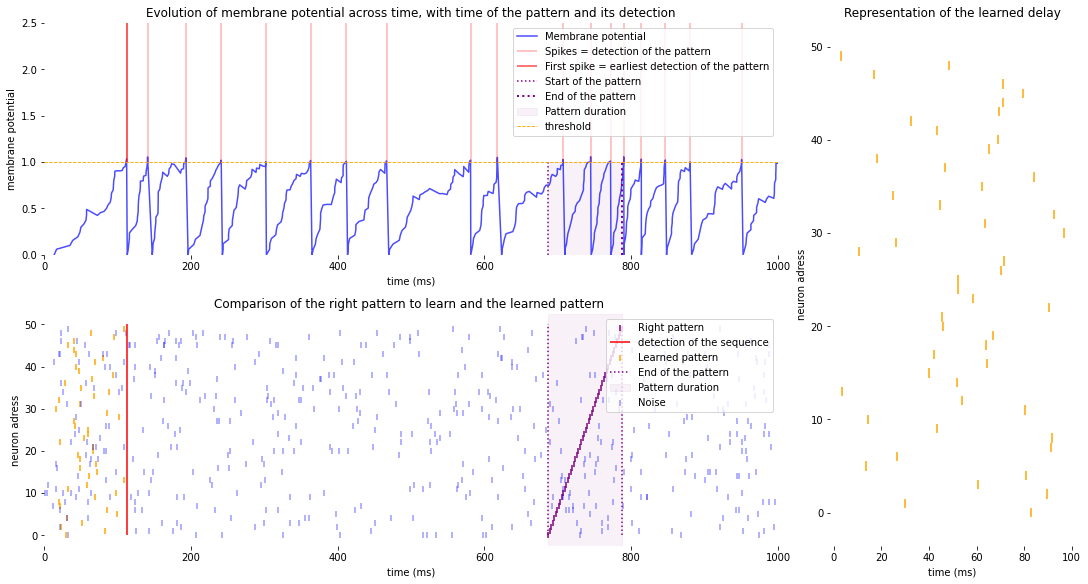

epoch : 0 seq : 1 motif : linear N : 2
687


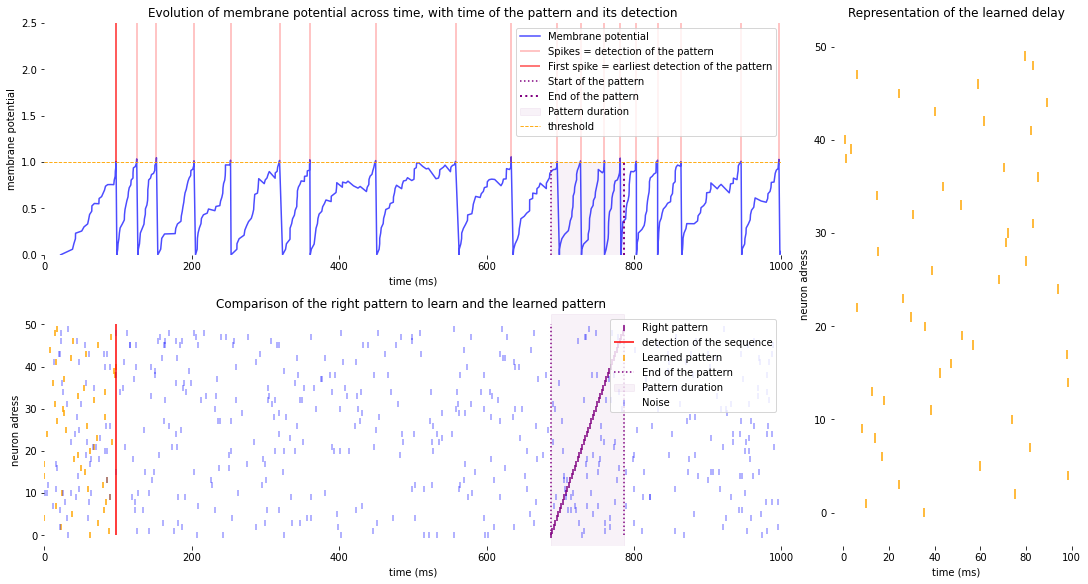

epoch : 0 seq : 2 motif : von Mises N : 0
282


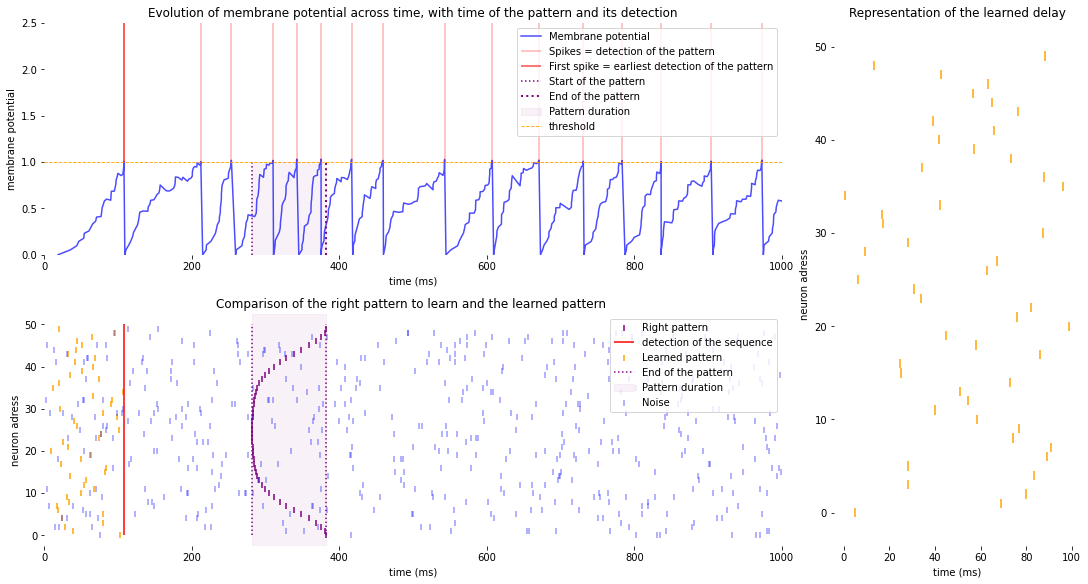

epoch : 0 seq : 2 motif : von Mises N : 1
282


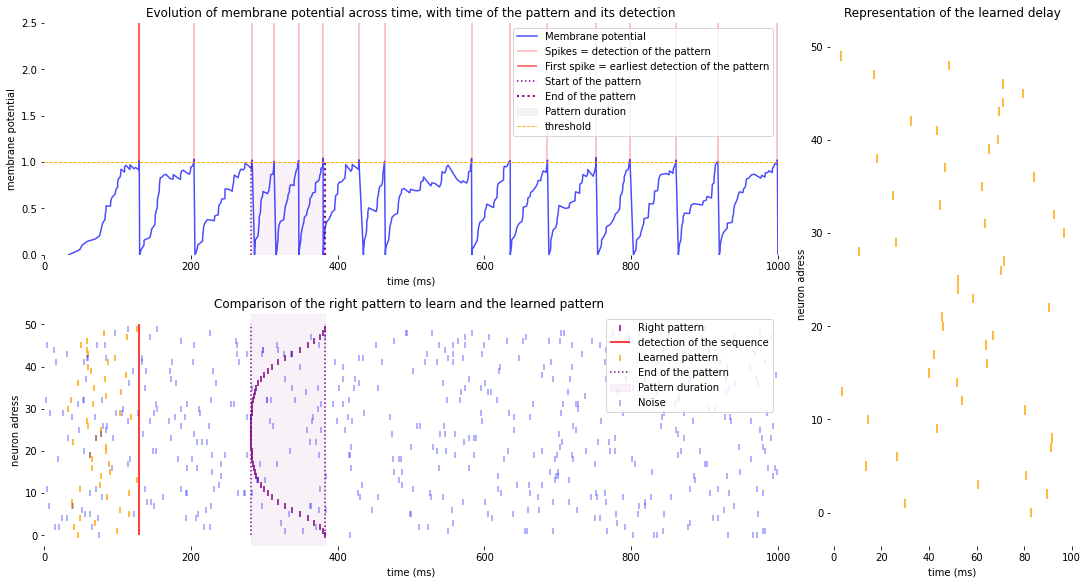

epoch : 0 seq : 2 motif : von Mises N : 2
282


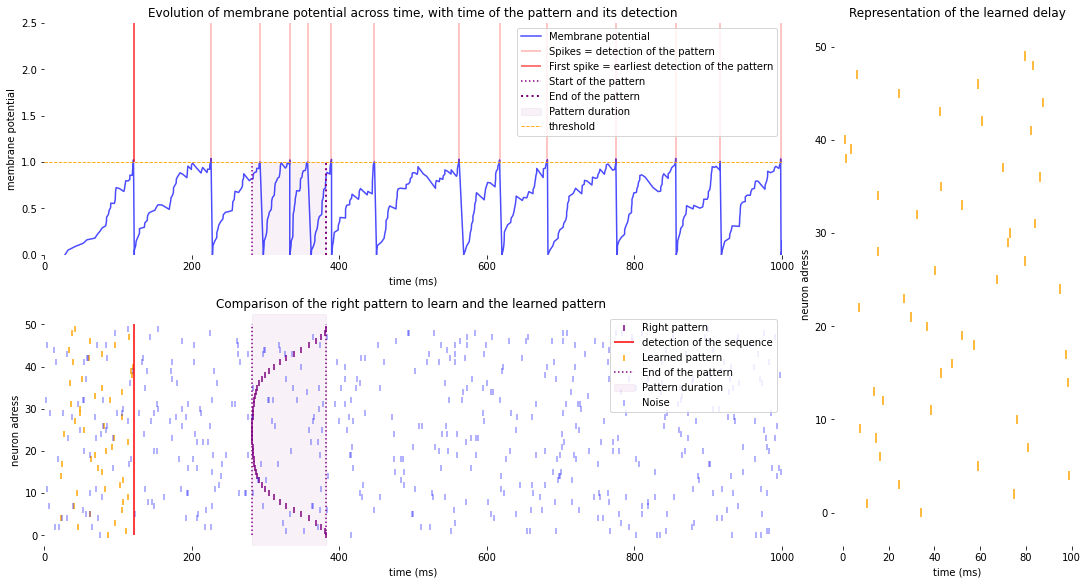

epoch : 350 seq : 0 motif : cosine N : 0
110


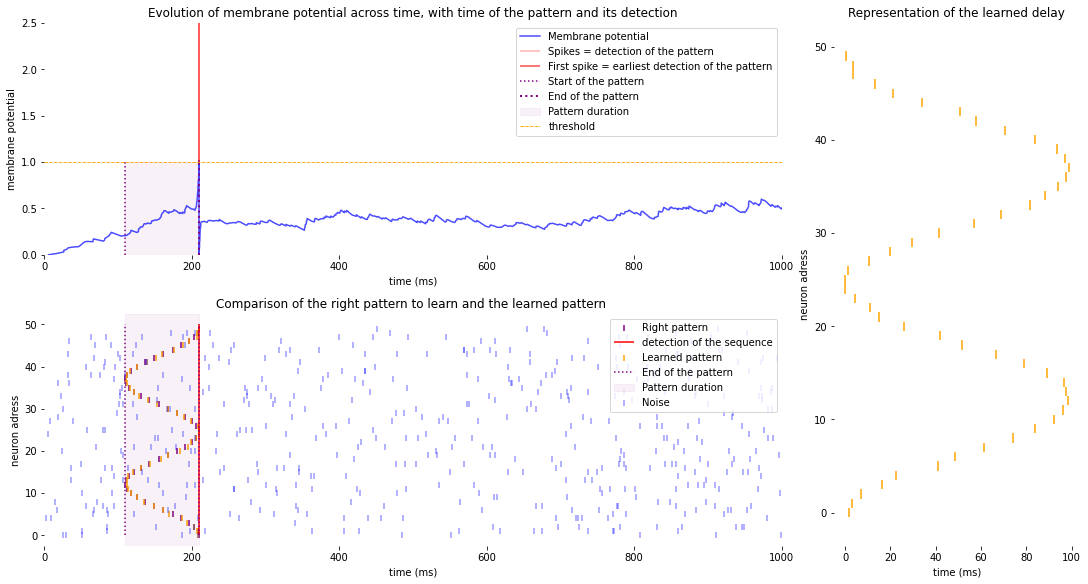

epoch : 350 seq : 0 motif : cosine N : 1
110


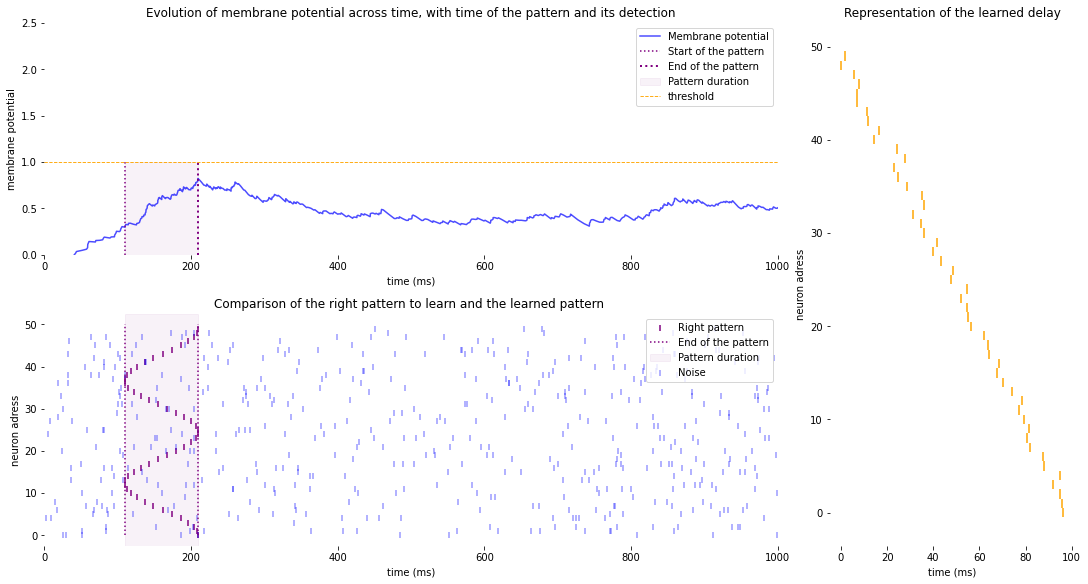

epoch : 350 seq : 0 motif : cosine N : 2
110


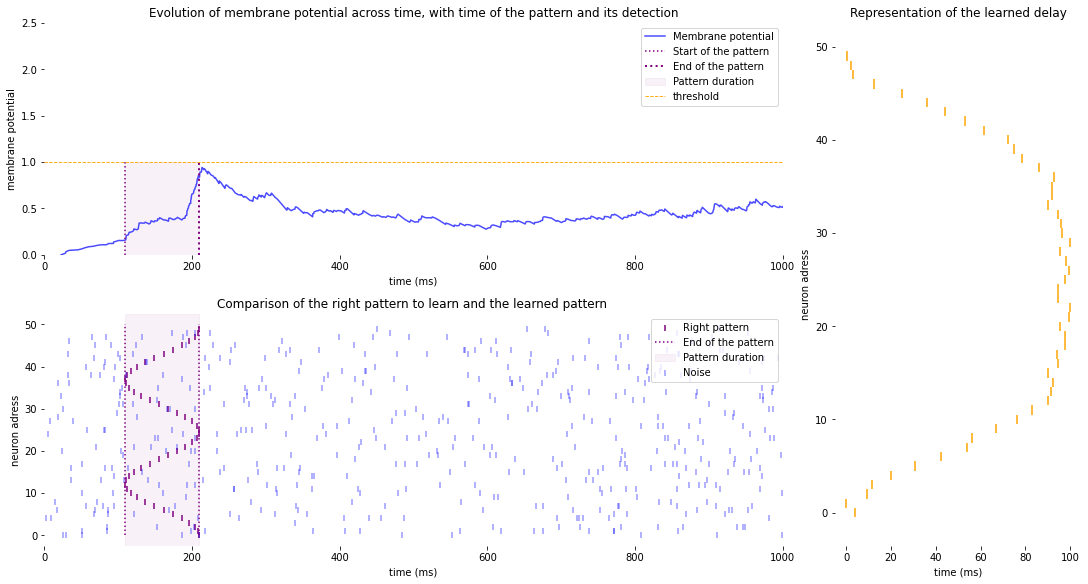

epoch : 350 seq : 1 motif : linear N : 0
401


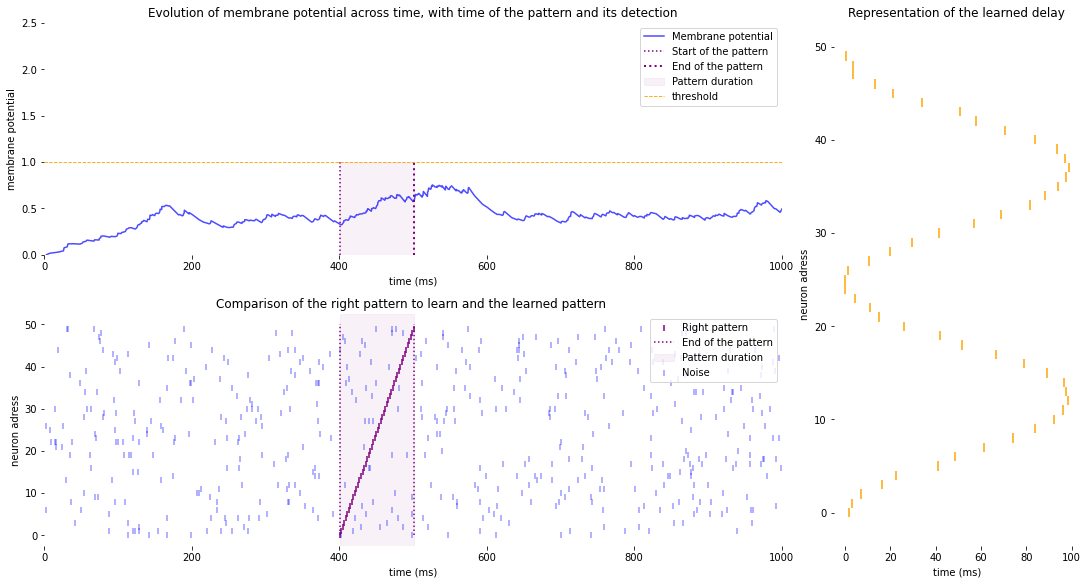

epoch : 350 seq : 1 motif : linear N : 1
401


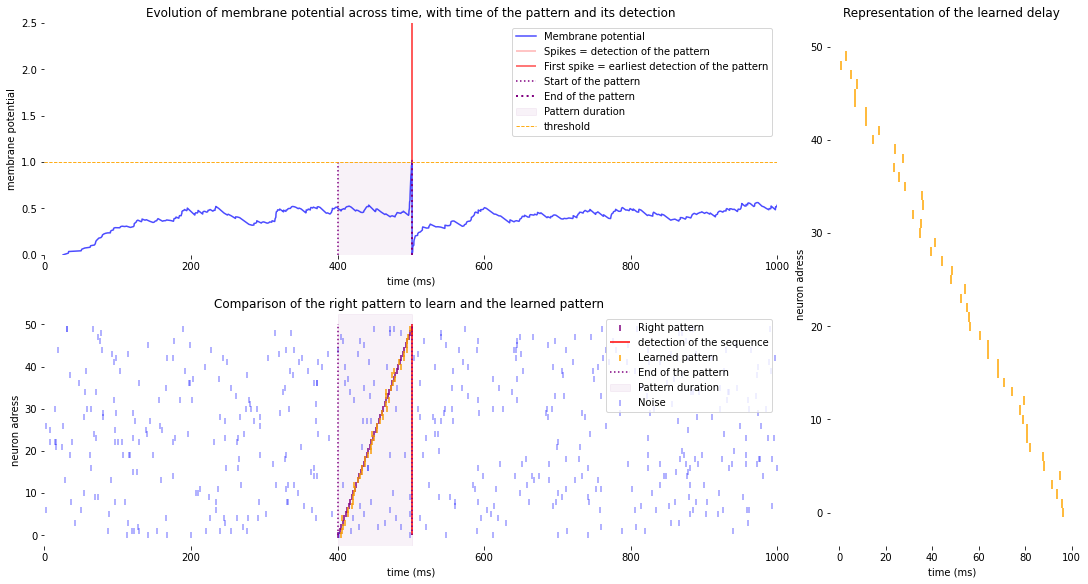

epoch : 350 seq : 1 motif : linear N : 2
401


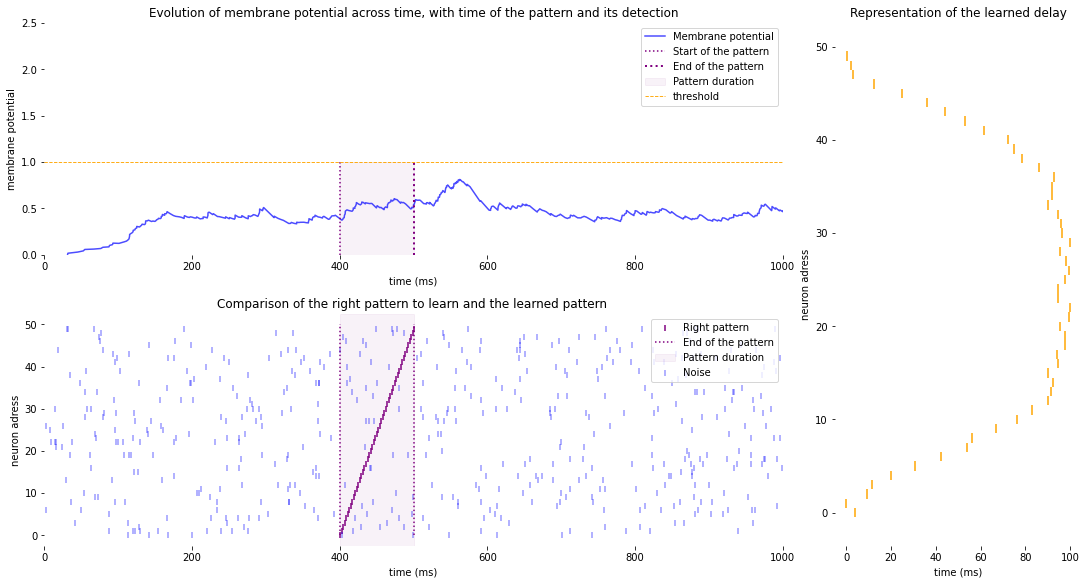

epoch : 350 seq : 2 motif : von Mises N : 0
102


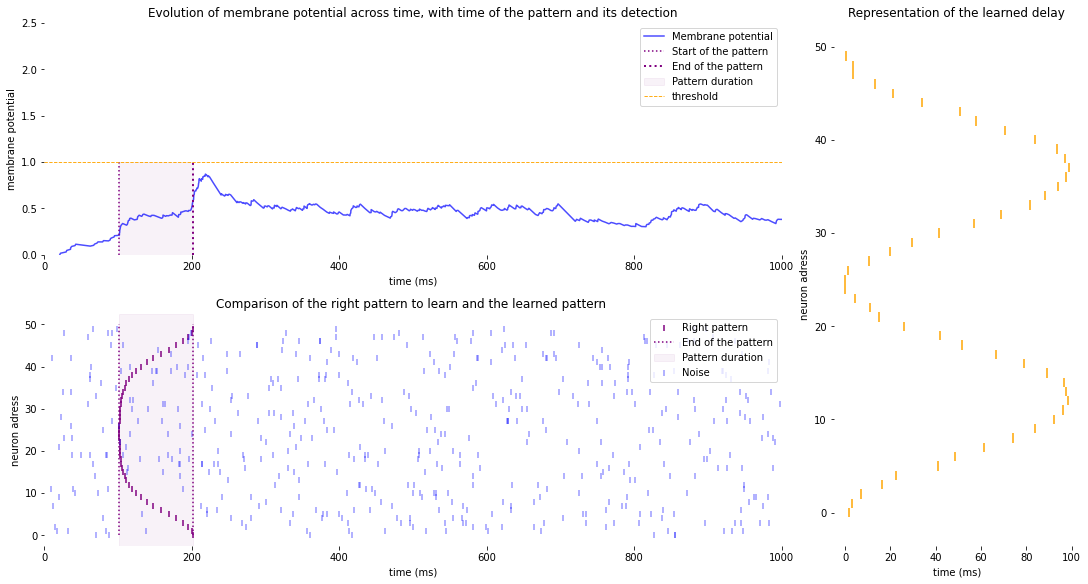

epoch : 350 seq : 2 motif : von Mises N : 1
102


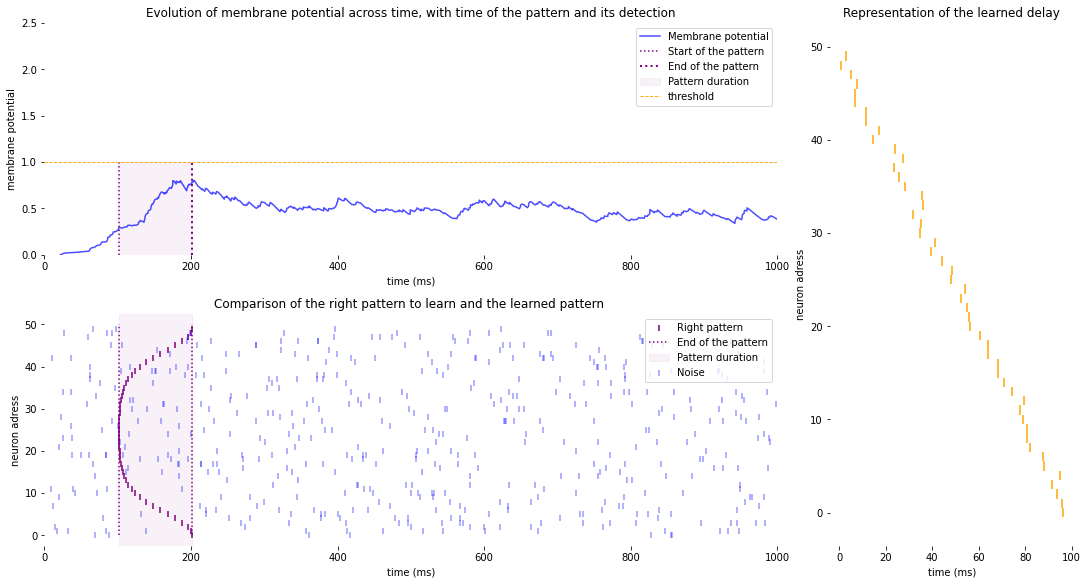

epoch : 350 seq : 2 motif : von Mises N : 2
102


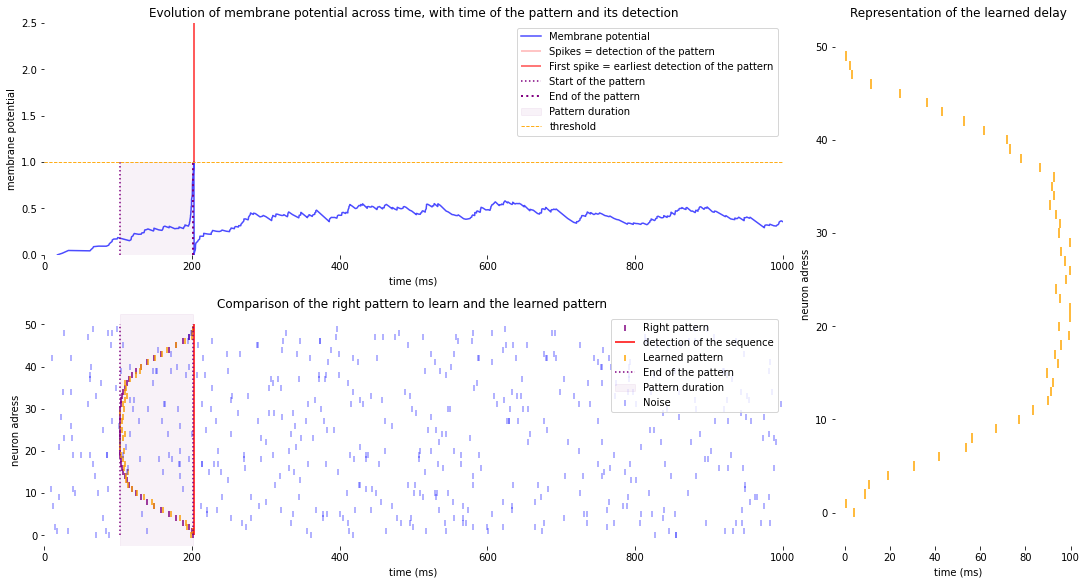

In [22]:
def learning(noise_density, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs=151, do_plot=True):
    motifs = [cospattern, linear, vonmises]
    motif_names = ['cosine', 'linear', 'von Mises']
    
    N = {} # neural assembly 
    for i in range(len(motifs)):
        N[i] = SD_neuron(nb_syn)
    sorted_times = {}
    V = {}

    for i_epoch in range(N_epochs):
        #func = motifs[np.random.randint(0,3)]
        for i in range(len(motifs)) :
            t_true = T + int(np.random.rand()*(simtime-3*T))
            
            aer_noise, aer_pattern, aer =  make_input(nb_syn, noise_density, simtime, T, t_true, function=motifs[i])
            addresses, timestamps = aer

            for k in range(len(N)):
                sorted_times[k], V[k] = N[k].code(aer)
                if V[k].max() > 1 : 
                    t_out = sorted_times[k][np.argmax(V[k]>1)]
                    #print('epoch :', i_epoch, 'N : ', i, 'N function :', motifs[i], 'actual function :', func, 'V.max', np.argmax(V[i]>1))
                    if i==k : # correct detection
                        time_error = (t_true+T) - t_out # delta_T, negative = too early, positive = too late -> supervision
                        Dweight = Dweight0 * np.tanh( - time_error / N[i].tau ) #STDP
                        N[k].weight *= 1 + Dweight
                    else : # incorrect detection
                        N[k].weight += -0.01

                if V[k].max() < 1 :
                    if i == k : # correct detection
                        Dweight = Dweight0
                        N[k].weight *= 1 + Dweight

                # STDP rule on the delays, event by event
                if i == k : # correct detection
                    for i_address, (address, timestamp) in enumerate(zip(addresses, timestamps)):
                    # predicted time by neuron:
                        pred_time = t_true + T - N[i].delays[address] # 
                    # timestamp is that of the i_address-th event - it is fired on synapse address
                        delay_pred_error = pred_time - timestamp # 
                    # STDP rule
                        Ddelay = Ddelay0 * np.tanh( delay_pred_error / N[k].tau ) * np.exp( - np.abs(delay_pred_error) / N[k].tau )

                    # clip delays
                        delay = N[k].delays[address]
                        delay += Ddelay
                        delay= np.min((delay, T))
                        delay = np.max((delay, 0))
                        N[k].delays[address] = delay


                if do_plot==True:
                    if i_epoch == 0 or i_epoch == N_epochs-1:
                        print('epoch :', i_epoch, 'seq :', i, 'motif :', motif_names[i], 'N :', k)
                    #if i_epoch % (N_epochs//10) == 0:
                    #print(i_epoch, i_epoch % (N_epochs//10), i_epoch // (N_epochs//10))
                        fig = plt.figure(constrained_layout=True, figsize = (15, 8))
                        axs = fig.subplot_mosaic(
                        """
                        AAAC
                        BBBC
                        """
                        )

                        axs['A'].plot(sorted_times[k], V[k], color='blue', alpha = .7, label = 'Membrane potential')
                        if V[k].max() > 1 : 
                            axs['A'].vlines(sorted_times[k][V[k]>1], 1, 2.5, color='red', alpha = .3, label = 'Spikes = detection of the pattern') # spike
                            axs['A'].vlines([t_out], 1, 2.5, color='red', alpha = .7, label = 'First spike = earliest detection of the pattern') # spike
                        print(t_true)
                        axs['A'].vlines([t_true], 0, 1, linestyles='dotted', color='purple', label = 'Start of the pattern')
                        axs['A'].vlines([t_true+T], 0, 1, linestyles='dotted', color='purple', lw = 2, label = 'End of the pattern')
                        axs['A'].axvspan( xmin = t_true, xmax = t_true+T, ymin=0, ymax=.4, color = 'purple', alpha = .05, label = 'Pattern duration')

                        axs['A'].hlines(1, 0, simtime, color = 'orange',linestyles='--', label = 'threshold', linewidth = .9)

                        axs['A'].set_xlim(0, simtime)
                        axs['A'].set_ylim(0, 2.5)

                        axs['A'].legend(loc = 'upper right')
                        axs['A'].set_xlabel('time (ms)')
                        axs['A'].set_ylabel('membrane potential')
                        axs['A'].set_title('Evolution of membrane potential across time, with time of the pattern and its detection')
                        axs['A'].spines['top'].set_visible(False)
                        axs['A'].spines['right'].set_visible(False)
                        axs['A'].spines['left'].set_visible(False)
                        axs['A'].spines['bottom'].set_visible(False)
                        adress_noise, time_noise = aer_noise
                        adress_pattern, time_pattern = aer_pattern
                        i_adress = np.arange(len(adress_pattern))

                        axs['B'].scatter(time_pattern, adress_pattern, marker='|', color='purple', label = 'Right pattern');
                        if V[k].max() > 1 : 
                            axs['B'].vlines(t_out, 0,50, color = 'red', label = 'detection of the sequence')
                            axs['B'].scatter(t_out - N[k].delays[:,np.newaxis], i_adress, marker = '|', color = 'orange', label = 'Learned pattern')

                        axs['B'].vlines(t_true, 0, 50, linestyles='dotted', color='purple')
                        axs['B'].vlines(t_true+T, 0, 50, color='purple', linestyles = 'dotted', label = 'End of the pattern')
                        axs['B'].axvspan(t_true, t_true+T, 0, 1, color = 'purple', alpha = .05, label = 'Pattern duration')

                        axs['B'].scatter(time_noise, adress_noise, marker='|', color='blue', alpha = .4, label = 'Noise')

                        axs['B'].set_xlim(0, simtime)
                        axs['B'].legend(loc = 'upper right')
                        axs['B'].set_xlabel('time (ms)')
                        axs['B'].set_ylabel('neuron adress')
                        axs['B'].set_title('Comparison of the right pattern to learn and the learned pattern ')
                        axs['B'].spines['top'].set_visible(False)
                        axs['B'].spines['right'].set_visible(False)
                        axs['B'].spines['left'].set_visible(False)
                        axs['B'].spines['bottom'].set_visible(False)

                        axs['C'].eventplot(N[k].delays[:,np.newaxis], color = 'orange')
                        axs['C'].set_xlabel('time (ms)')
                        axs['C'].set_ylabel('neuron adress')
                        axs['C'].set_title('Representation of the learned delay')
                        axs['C'].spines['top'].set_visible(False)
                        axs['C'].spines['right'].set_visible(False)
                        axs['C'].spines['left'].set_visible(False)
                        axs['C'].spines['bottom'].set_visible(False)
                        plt.show()

                    
    return N

N = learning(noise_density, T, Dweight0 = 1e-1, Ddelay0 = 2., N_epochs = 351, do_plot=True)
